# 一维拉力梁

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
import matplotlib.pyplot as plt
from pyDOE import lhs
%matplotlib inline
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 20
        self.net = nn.Sequential(
            nn.Linear(1, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [3]:
def u_function(y):
    u = model(y)
    return u

def fi(e):
    return (1 + e)**1.5 - 1.5 * e - 1

def dfi_de(e):
    return 1.5 * (1 + e)**0.5 - 1.5

def f_function(x):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dfi = dfi_de(u_x)
    dfi_dx = torch.autograd.grad(dfi, x, torch.ones_like(dfi), retain_graph=True, create_graph=True)[0]
    f = dfi_dx + x
    ut_loss = torch.mean(dfi[-1]**2)
    return f, ut_loss
    
def Loss(x_f, t):
    f_pre, ut_loss = f_function(x_f)
    # loss
    null =  torch.zeros((f_pre.shape[0], 1))
    f_loss = loss_fn(f_pre, null)
    
    x_u = torch.tensor(np.array([-1]), dtype=torch.float32, requires_grad=True)
    x_L = torch.tensor(np.array([L]), dtype=torch.float32, requires_grad=True)
    
    u_loss = torch.mean((u_function(x_u))**2)
    ls = u_loss + f_loss + ut_loss
    ls.backward()
    return ls

def Exact_u(x):
    u = (68 + 105 * x - 40 * x**3 + 3 * x**5) / 135
    return u

[Epoch 1/2000] [loss: 0.3417854905128479]
[Epoch 101/2000] [loss: 0.0002654853742569685]
[Epoch 201/2000] [loss: 0.0032909060828387737]
[Epoch 301/2000] [loss: 6.0964099247939885e-05]
[Epoch 401/2000] [loss: 0.014572031795978546]
[Epoch 501/2000] [loss: 3.0437224268098362e-05]
[Epoch 601/2000] [loss: 1.3770137229585089e-05]
[Epoch 701/2000] [loss: 5.819506441184785e-06]
[Epoch 801/2000] [loss: 2.2243223156692693e-06]
[Epoch 901/2000] [loss: 1.343205212833709e-06]
[Epoch 1001/2000] [loss: 8.003696621017298e-07]
[Epoch 1101/2000] [loss: 4.867009124609467e-07]
[Epoch 1201/2000] [loss: 3.165378927860729e-07]
[Epoch 1301/2000] [loss: 2.6521826157477335e-07]
[Epoch 1401/2000] [loss: 2.2778779396048776e-07]
[Epoch 1501/2000] [loss: 2.0089137819923053e-07]
[Epoch 1601/2000] [loss: 1.8173248861330649e-07]
[Epoch 1701/2000] [loss: 1.742813964256129e-07]
[Epoch 1801/2000] [loss: 1.677552603496224e-07]
[Epoch 1901/2000] [loss: 1.620825145209892e-07]


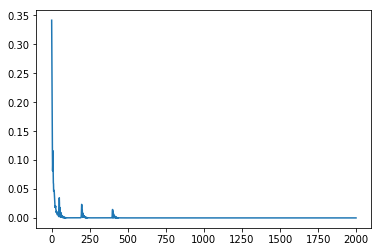

In [4]:
L = 1
t = 0
N_f = 5000
X_f_train = np.linspace(-1, L, N_f)
x_f = torch.tensor(X_f_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

model = MLP()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.5)
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(x_f, t)
    Losses.append(loss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

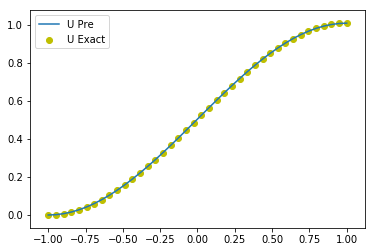

In [5]:
x = torch.linspace(-1, L, 40).reshape(-1,1)
Upre = u_function(x)
xnp = x.detach().numpy()
Unp = Upre.detach().numpy()
Uex = Exact_u(xnp)
plt.plot(x,Unp,label='U Pre')
plt.scatter(x,Uex,label='U Exact',color='y')
plt.legend()
plt.show()

# 二维弯曲梁

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
class MLP(torch.nn.Module):
    def __init__(self, D_in=2, H=30, D_out=2):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)

        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)

    def forward(self, x):
        y1 = torch.tanh(self.linear1(x))
        y2 = torch.tanh(self.linear2(y1))
        y3 = torch.tanh(self.linear3(y2))
        y = self.linear4(y3)
        u=y[:,0]
        v=y[:,1]
        return u.view(-1,1),v.view(-1,1)

In [7]:
L = 4
H = 1
t = -5 # point load
E = 1000 # Young modulus
v = 0.3 # Poisson ratio
V = L * H
Lam = (E * v) / ((1 + v) * (1 - 2 * v))
Mu = E / (2 * (1 + v))

def Fi(x, y):
    u, v = u_function(x, y)
    # 计算偏导数
    dX_dx = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]+1
    dX_dy = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dY_dx = torch.autograd.grad(v, x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    dY_dy = torch.autograd.grad(v, x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]+1
    
    J = dX_dx*dY_dy-dX_dy*dY_dx
    I = dX_dx**2+dY_dy**2+dX_dy**2+dY_dx**2
    
    fi = 0.5 * Lam * (torch.log(J) * torch.log(J)) - Mu * torch.log(J) + 0.5 * Mu * (I - 2)
    return fi

def u_function(x,y):
    u, v = model(torch.hstack((x, y)))
    u = x * u
    v = x * v
    return u, v

def f_function(x, y, x_u, y_u):
    Fi_Nb = Fi(x, y)
    u_u, v_u = u_function(x_u, y_u)
    value = t * (y_u + v_u)
    f = L * H * torch.sum(Fi_Nb) / Fi_Nb.data.nelement()
    g = L * torch.sum(value) / value.data.nelement()

    return f - g
    
def Loss(x_f, y_f, x_u, y_u):
    ls = f_function(x_f, y_f, x_u, y_u)

    ls.backward()
    return ls

[Epoch 1/2000] [loss: 11.73494815826416]
[Epoch 301/2000] [loss: 9.332983016967773]
[Epoch 601/2000] [loss: 9.332775115966797]
[Epoch 901/2000] [loss: 9.332732200622559]
[Epoch 1201/2000] [loss: 9.332724571228027]
[Epoch 1501/2000] [loss: 9.332723617553711]
[Epoch 1801/2000] [loss: 9.332725524902344]


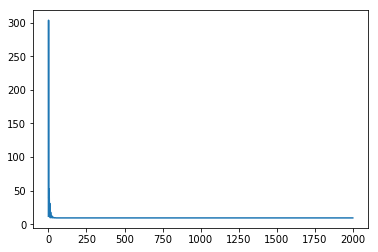

In [8]:
N1 = 200
N2 = 50
x = np.linspace(0,L,N1)
y = np.linspace(0,H,N2)
X, Y = np.meshgrid(x,y)

x_f = torch.tensor(X.reshape(-1,1), dtype=torch.float32, requires_grad=True)
y_f = torch.tensor(Y.reshape(-1,1), dtype=torch.float32, requires_grad=True)

x_right = np.ones((N2,1)) * L
y_right = np.linspace(0,H,N2).reshape(-1,1)

X_u_train = np.hstack((x_right,y_right))

x_u = torch.tensor(X_u_train[:,0].reshape(-1,1), dtype=torch.float32, requires_grad=True)
y_u = torch.tensor(X_u_train[:,1].reshape(-1,1), dtype=torch.float32, requires_grad=True)

model = MLP()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
epochs = 2000
Losses = []
F = []
G = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(x_f, y_f, x_u, y_u)
    Losses.append(loss.item())
    if epoch % 300 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()

plt.plot(Losses)
plt.show()

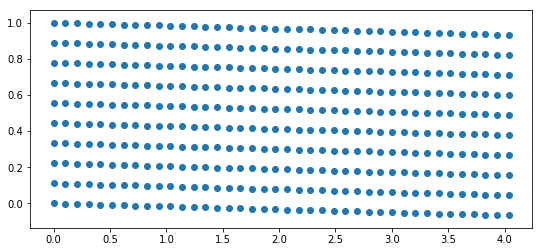

In [9]:
N1 = 40
N2 = 10
x = torch.linspace(0,L,N1)
y = torch.linspace(0,H,N2)
X, Y = torch.meshgrid(x,y)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
plt.figure(figsize=(9,4))
u, v = u_function(X,Y)
xx = X + u
yy = Y + v
xnp = xx.detach().numpy()
ynp = yy.detach().numpy()
plt.scatter(xnp,ynp)
plt.show()

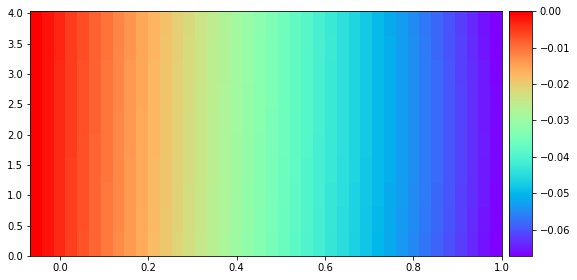

In [10]:
xnp = xnp.reshape(N1,N2).T
ynp = ynp.reshape(N1,N2).T
Unp = v.detach().numpy().reshape(N1,N2).T
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='rainbow', 
              extent=[ynp.min(), ynp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

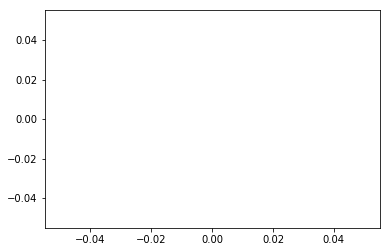

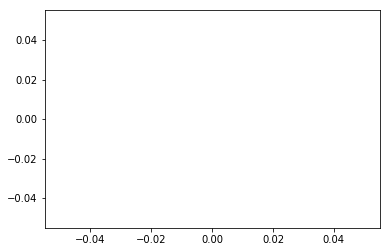

In [6]:
plt.plot(F)
plt.show()
plt.plot(G)
plt.show()

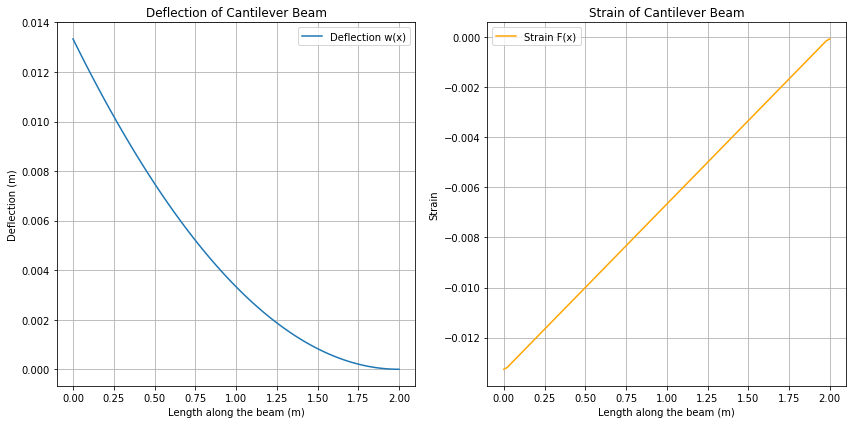

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 参数定义
P = 1000  # 施加的力 (N)
L = 2.0   # 悬臂梁长度 (m)
E = 200e9 # 杨氏模量 (Pa)
I = 1e-6  # 截面惯性矩 (m^4)

# 计算变形
x = np.linspace(0, L, 100)  # 从固定端到自由端的长度
w = (P * L**3 / (3 * E * I)) * (1 - x/L)**2  # 变形公式

# 计算变形梯度
F = np.gradient(w, x)  # 计算变形梯度

# 绘制变形和变形梯度
plt.figure(figsize=(12, 6))

# 变形图
plt.subplot(1, 2, 1)
plt.plot(x, w, label='Deflection w(x)')
plt.title('Deflection of Cantilever Beam')
plt.xlabel('Length along the beam (m)')
plt.ylabel('Deflection (m)')
plt.grid()
plt.legend()

# 变形梯度图
plt.subplot(1, 2, 2)
plt.plot(x, F, label='Strain F(x)', color='orange')
plt.title('Strain of Cantilever Beam')
plt.xlabel('Length along the beam (m)')
plt.ylabel('Strain')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
